In [1]:
import pandas as pd
import glob2
import os

### 1) Combining The 12 month data into a single dataset

In [2]:
path = os.getcwd() + "/data"
filenames = glob2.glob(path + "/*.csv")

dfs = []
for filename in filenames:
    df = pd.read_csv(filename)
    dfs.append(df)

In [3]:
# Check that all column names in all dataframes are identical so
# that we can us pd.concat and save some headaches
def areColumnNamesIdentical(dfs: list):
    # TODO: check for number of columns in each df
    for df in dfs:
        if not all(dfs[0].columns == df.columns):
            return False
    return True


if areColumnNamesIdentical(dfs):
    df = pd.concat(dfs, join="outer", axis=0, ignore_index=True)

del dfs
df.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,EC2DE40644C6B0F4,classic_bike,2022-05-23 23:06:58,2022-05-23 23:40:19,Wabash Ave & Grand Ave,TA1307000117,Halsted St & Roscoe St,TA1309000025,41.891466,-87.626761,41.943670,-87.648950,member
1,1C31AD03897EE385,classic_bike,2022-05-11 08:53:28,2022-05-11 09:31:22,DuSable Lake Shore Dr & Monroe St,13300,Field Blvd & South Water St,15534,41.880958,-87.616743,41.886349,-87.617517,member
2,1542FBEC830415CF,classic_bike,2022-05-26 18:36:28,2022-05-26 18:58:18,Clinton St & Madison St,TA1305000032,Wood St & Milwaukee Ave,13221,41.882242,-87.641066,41.907655,-87.672552,member
3,6FF59852924528F8,classic_bike,2022-05-10 07:30:07,2022-05-10 07:38:49,Clinton St & Madison St,TA1305000032,Clark St & Randolph St,TA1305000030,41.882242,-87.641066,41.884576,-87.631890,member
4,483C52CAAE12E3AC,classic_bike,2022-05-10 17:31:56,2022-05-10 17:36:57,Clinton St & Madison St,TA1305000032,Morgan St & Lake St,TA1306000015,41.882242,-87.641066,41.885779,-87.651025,member


In [4]:
df.shape

(5859061, 13)

In [5]:
df.dtypes

ride_id                object
rideable_type          object
started_at             object
ended_at               object
start_station_name     object
start_station_id       object
end_station_name       object
end_station_id         object
start_lat             float64
start_lng             float64
end_lat               float64
end_lng               float64
member_casual          object
dtype: object

In [6]:
# changing times to datetime from object for easy comparisons
df["started_at"] = pd.to_datetime(df["started_at"], format="%Y-%m-%d %H:%M:%S")
df["ended_at"] = pd.to_datetime(df["ended_at"], format="%Y-%m-%d %H:%M:%S")
df.dtypes

ride_id                       object
rideable_type                 object
started_at            datetime64[ns]
ended_at              datetime64[ns]
start_station_name            object
start_station_id              object
end_station_name              object
end_station_id                object
start_lat                    float64
start_lng                    float64
end_lat                      float64
end_lng                      float64
member_casual                 object
dtype: object

#### 2) Check for duplicates

In [7]:
# Identical Rows?
any(df.duplicated())

False

In [8]:
# Duplicate Ride IDs?
any(df.duplicated(subset=["ride_id"]))

False

In [9]:
# Duplicate Rides?
df.duplicated(
    subset=[
        "started_at",
        "ended_at",
        "start_lat",
        "start_lng",
        "end_lat",
        "end_lng",
        "member_casual",
        "start_station_name",
        "end_station_name",
    ]
).value_counts()

False    5859040
True          21
Name: count, dtype: int64

21 rides have started and ended at the exact same time and locations. Without further identifying information it's not possible to tell whether this is a companion ride or a software issue, but due to the small sample size, there is no need to dig further and it can be safely assumed to be companion rides.

### 3) Checking for missing values

In [10]:
df.isna().sum()

ride_id                    0
rideable_type              0
started_at                 0
ended_at                   0
start_station_name    832009
start_station_id      832141
end_station_name      889661
end_station_id        889802
start_lat                  0
start_lng                  0
end_lat                 5973
end_lng                 5973
member_casual              0
dtype: int64

**About 15% of data has missing start and end station name**. However only a tiny percentage of end GPS coordinates are missing. We can try to reverse engineer the street names from GPS coordinates using geopy.

### Which dates are most of the missing values from?

In [11]:
def amountNullInCol(df, col):
    return df[col].isnull().value_counts()


def getRowsWhereObsMissing(df, col1, col2):
    """
    return df where observation is null in atleast one of the two columns
    without duplicate observations
    """
    df1 = df[df[col1].isnull()]
    df2 = df[df[col2].isnull()]
    return pd.concat([df1, df2]).drop_duplicates()


df1 = getRowsWhereObsMissing(df, "start_station_name", "end_station_name")
df1.shape

(1324816, 13)

**So we have 1.3m (22%) observations that have one of the station names missing or both. Where are they all from?**

In [12]:
_map = {
    5: "May '22",
    6: "June '22",
    7: "Jul '22",
    8: "Aug '22",
    9: "Sep '22",
    10: "Oct '22",
    11: "Nov '22",
    12: "Dec '22",
    1: "Jan '23",
    2: "Feb '23",
    3: "March '23",
    4: "Apr '23",
}
df1["started_at"] = df1["started_at"].dt.month.map(_map)
df1["ended_at"] = df1["ended_at"].dt.month.map(_map)

<Axes: title={'center': 'Missing Station Names by Month'}>

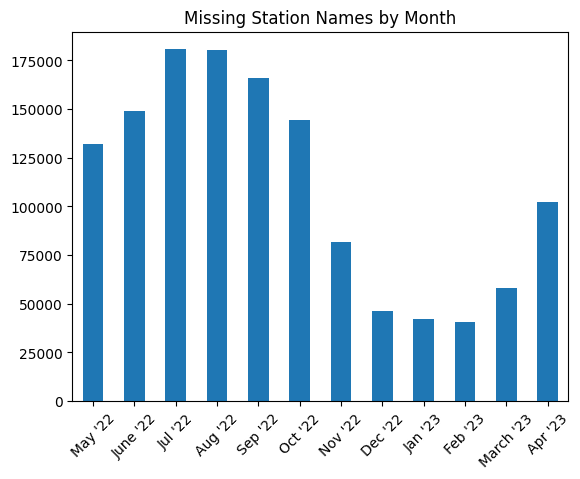

In [13]:
df1["ride_id"].groupby(df1["started_at"], sort=False).count().plot(
    kind="bar", title="Missing Station Names by Month", xlabel="", rot=45
)

The majority of missing station names are from 2022. There is a sharp decline into 2023. Since most of GPS values are in the table for most of the observations, this implies it is an administrative or software error. It would be interesting to see if there are any associations between GPS location and missing station names.

Dropping the missing station names, we would lose a disproportionately larger amount of data from 2022 than in 2023. It is unecessary to drop the values since it is possible to reverse geocode the street names from the gps coordinates in the future.

In [14]:
del df1
del _map

#### 4) Adding Useful Columns

In [15]:
def rmUnuseableRows(df):
    """
    return df with rows dropped that have null in specified column
    """
    dfExclude = df[df["end_lat"].isnull()]
    return df.drop(index=dfExclude.index)


def populateGPSCols(df):
    df["start_gps"] = (
        df["start_lat"].astype("str") + ", " + df["start_lng"].astype("str")
    )
    # TODO: some end lats/lngs are NaN. Check for them
    df["end_gps"] = df["end_lat"].astype("str") + ", " + df["end_lng"].astype("str")
    return df


def timeToClass(x):
    if 7 <= x <= 12:
        return "Morning"
    elif 12 < x <= 17:
        return "Afternoon"
    elif 17 < x <= 21:
        return "Evening"
    else:
        return "Night"


df = rmUnuseableRows(df)
df = populateGPSCols(df)
df.insert(3, column="started_hour", value=df["started_at"].dt.hour)
df.insert(4, column="month", value=df["started_at"].dt.month_name())
df.insert(5, column="day_of_week", value=df["started_at"].dt.day_name())
df.insert(
    7,
    column="ride_length_mins",
    value=(df["ended_at"] - df["started_at"]).dt.total_seconds() / 60,
)
df["time_type"] = df["started_hour"].apply(timeToClass)

df.head()

,ride_id,rideable_type,started_at,started_hour,month,day_of_week,ended_at,ride_length_mins,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,start_gps,end_gps,time_type
0,EC2DE40644C6B0F4,classic_bike,2022-05-23 23:06:58,23,May,Monday,2022-05-23 23:40:19,33.350000,Wabash Ave & Grand Ave,TA1307000117,Halsted St & Roscoe St,TA1309000025,41.891466,-87.626761,41.943670,-87.648950,member,"41.891466, -87.626761","41.94367, -87.64895",Night
1,1C31AD03897EE385,classic_bike,2022-05-11 08:53:28,8,May,Wednesday,2022-05-11 09:31:22,37.900000,DuSable Lake Shore Dr & Monroe St,13300,Field Blvd & South Water St,15534,41.880958,-87.616743,41.886349,-87.617517,member,"41.880958, -87.616743","41.88634906269, -87.6175165471",Morning
2,1542FBEC830415CF,classic_bike,2022-05-26 18:36:28,18,May,Thursday,2022-05-26 18:58:18,21.833333,Clinton St & Madison St,TA1305000032,Wood St & Milwaukee Ave,13221,41.882242,-87.641066,41.907655,-87.672552,member,"41.882242, -87.641066","41.907655, -87.672552",Evening
3,6FF59852924528F8,classic_bike,2022-05-10 07:30:07,7,May,Tuesday,2022-05-10 07:38:49,8.700000,Clinton St & Madison St,TA1305000032,Clark St & Randolph St,TA1305000030,41.882242,-87.641066,41.884576,-87.631890,member,"41.882242, -87.641066","41.884576228, -87.63188991",Morning
4,483C52CAAE12E3AC,classic_bike,2022-05-10 17:31:56,17,May,Tuesday,2022-05-10 17:36:57,5.016667,Clinton St & Madison St,TA1305000032,Morgan St & Lake St,TA1306000015,41.882242,-87.641066,41.885779,-87.651025,member,"41.882242, -87.641066","41.88577925240433, -87.65102460980414",Afternoon


#### 5) Checking that ride_length is realistic

Rides that are longer than 10 hours are assumed to be people forgetting to register their ending station rides. Also, this is the upper limit for bikes being used for work and leisure purposes.

In [16]:
dfImpossible = df[df["ride_length_mins"] > 600]
df = df.drop(index=dfImpossible.index)
del dfImpossible

We cannot have ending times earlier than starting times. We drop these.

In [17]:
dfImpossible = df[df["ride_length_mins"] <= 0]
df = df.drop(index=dfImpossible.index)
del dfImpossible

We drop rides less than 2 minutes long with the same starting and ending positions, as we can assume that these are accidental AND rides that are less than a minute long. This is because it can be safely assumed that the vast majority of these are accidental uses and not deliberate use as transport.

In [18]:
dfNoRide = df[(df["ride_length_mins"] < 2) & (df["start_gps"] == df["end_gps"])]
dfNoRide
df = df.drop(index=dfNoRide.index)
del dfNoRide

dfNoRide = df[(df["ride_length_mins"] < 1)]
dfNoRide
df = df.drop(index=dfNoRide.index)
del dfNoRide

#### 6) Dropping other datapoints that are unlikely to be "real rides"
4 decimal place resolution of longitude/latitude corresponds to a metre. This means that if start and end gps are the exact same down to the resolution, it is much more likely that that the bike was put out by accident, then used as a ride and placed back in the exact same spot down to the centimetre. For this reason the datapoints will be dropped.

In [19]:
dfNoRide = df[(df["start_gps"] == df["end_gps"])]
df = df.drop(index=dfNoRide.index)
del dfNoRide

#### 7) Exploring Differences between casual and annual members

In [20]:
df["member_casual"].describe()

count     5480505
unique          2
top        member
freq      3322642
Name: member_casual, dtype: object

In [21]:
df[
    [
        "day_of_week",
        "start_station_id",
        "rideable_type",
        "ride_length_mins",
        "start_station_name",
        "member_casual",
    ]
].groupby(by=["member_casual"]).describe()

ride_length_mins                                       \
                         count       mean        std  min       25%   
member_casual                                                         
casual               2157863.0  19.880579  25.299889  1.0  7.433333   
member               3322642.0  12.196728  13.667767  1.0  5.300000   

                                                 
                     50%        75%         max  
member_casual                                    
casual         12.633333  22.600000  599.383333  
member          8.883333  15.083333  599.433333

In [22]:
df[["start_station_name", "end_station_name", "member_casual"]].groupby(
    by=["member_casual"]
).describe()

start_station_name                                          \
                           count unique                       top   freq   
member_casual                                                              
casual                   1863530   1621   Streeter Dr & Grand Ave  48969   
member                   2889821   1510  Kingsbury St & Kinzie St  24739   

              end_station_name                                          
                         count unique                       top   freq  
member_casual                                                           
casual                 1814485   1624   Streeter Dr & Grand Ave  51428  
member                 2902086   1495  Kingsbury St & Kinzie St  24702

In [23]:
df.isnull().sum()

ride_id                    0
rideable_type              0
started_at                 0
started_hour               0
month                      0
day_of_week                0
ended_at                   0
ride_length_mins           0
start_station_name    727154
start_station_id      727277
end_station_name      763934
end_station_id        764069
start_lat                  0
start_lng                  0
end_lat                    0
end_lng                    0
member_casual              0
start_gps                  0
end_gps                    0
time_type                  0
dtype: int64

#### 7) Save the df to file

In [24]:
df.to_csv(path + "/processed/tripdata.csv", index=False)